In [136]:
import numpy as np
from pprint import pprint
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
import warnings
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
warnings.filterwarnings('ignore')

In [12]:
def my_accuracy(y_true, y_pred):
    y_pred = np.where(y_pred > 0.5, 1, 0)
    return accuracy_score(y_true, y_pred)

def plot_gs_results(gs_model, params, check_params, model_name = ''):
    plt.figure(figsize=(12,6))
    ## plt.title(model_name + " dependency from "+ str(check_params))
    plt.plot(params[check_params], gs_model.cv_results_["mean_train_score"],"o-",label="train")
    plt.plot(params[check_params], gs_model.cv_results_["mean_test_score"],"o-",label="test")
    plt.xlabel(check_params)
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

def gs_regressor_params(parameters ={}, check_parameter={}, metric="accuracy", reg=None, n_splits=1, test_size=0.20):
    metric = make_scorer(my_accuracy)
    cv = TimeSeriesSplit(n_splits=n_splits)
    gs_reg = GridSearchCV(reg, parameters, cv=cv, scoring=metric, return_train_score=True, verbose=False)
    gs_reg.fit(X_train,y_train)
    plot_gs_results(gs_model=gs_reg, params=parameters, check_params = check_parameter, model_name=str(reg))

In [13]:
data = pd.read_pickle('final_data.pkl')
print(data.shape)
data.head(1)

(34588, 132)


,,,Surface,hour,round,p1_win,p1_age,p2_age,k1,k2,p1_height,p2_height,...,p2_filter_lag_1_receiver_points_won_match__mean_28,p2_filter_lag_1_receiver_points_won_match__median_28,p1_lag_1_match_duration_mnt_mean_28,p1_lag_1_match_duration_mnt_median_28,p1_filter_lag_1_match_duration_mnt_mean_28,p1_filter_lag_1_match_duration_mnt_median_28,p2_lag_1_match_duration_mnt_mean_28,p2_lag_1_match_duration_mnt_median_28,p2_filter_lag_1_match_duration_mnt_mean_28,p2_filter_lag_1_match_duration_mnt_median_28
date,p1,p2,,,,,,,,,,,,,,,,,,,,,
2015-06-01,Gasquet R.,Djokovic N.,0.0,18,1.0,0,28.046575,28.972603,19.0,1.0,1.88,1.83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
y = data['p1_win'].astype(int)
X = data.drop(['p1_win'], axis=1)
date_idx = X.index.get_level_values('date')

In [15]:
test_periods = [
    ('2019-01-01', '2019-04-01'),
    ('2019-04-01', '2019-07-01'),
    ('2019-07-01', '2019-10-01'),
    ('2019-10-01', '2020-04-01'),
    ('2020-08-01', '2020-11-01'),
]

for p in test_periods:
    n_test = data[(date_idx >= p[0]) & (date_idx < p[1])].shape[0]
    print('test period: {}, match count: {:,}'.format(p, n_test))

test period: ('2019-01-01', '2019-04-01'), match count: 2,022
test period: ('2019-04-01', '2019-07-01'), match count: 2,034
test period: ('2019-07-01', '2019-10-01'), match count: 2,046
test period: ('2019-10-01', '2020-04-01'), match count: 2,424
test period: ('2020-08-01', '2020-11-01'), match count: 1,664


In [89]:
test_from, test_to = test_periods[0]
d = date_idx
X_test = X[(date_idx >= test_from) & (date_idx < test_to)]
y_test = y[(date_idx >= test_from) & (date_idx < test_to)]
## X_train = X[(date_idx < test_from)]
## y_train = y[(date_idx < test_from)]
X_train = X[(date_idx < test_from) & (date_idx  >= '2017-01-01')]
y_train = y[(date_idx < test_from) & (date_idx >= '2017-01-01')]
X_2019 = X[(date_idx >= '2019-01-01') & (date_idx < '2020-01-01')]

In [22]:

grid_params = {
    'learning_rate': [0.01], 
    'max_depth': [2],
    'subsample': [0.4],
    'colsample_bytree': [0.8],
    'n_estimators': [260],
    'eval_metric' :["logloss"]
}
metric = make_scorer(my_accuracy)
cv = TimeSeriesSplit(n_splits=10)
gs_reg = GridSearchCV(xgb.XGBClassifier(n_jobs=3), grid_params, cv=cv, scoring=metric, return_train_score=True, verbose=False)
model = gs_reg.fit(X_train,y_train)


In [263]:
xgpred_upgrade = np.zeros(7000 * 2).reshape(7000, 2)
date = datetime.datetime(2019, 1, 1)
start = 0
while (date < datetime.datetime(2020, 1, 1)):
    start_time = time.time()
    wall = date.strftime("%Y-%m-%d")
    XX_test = X[(date_idx >= wall) & (date_idx < (date + datetime.timedelta(days=7)).strftime("%Y-%m-%d"))]
    yy_test = y[(date_idx >= wall) & (date_idx < (date + datetime.timedelta(days=7)).strftime("%Y-%m-%d"))]
    XX_train = X[(date_idx < wall) & (date_idx  >= '2017-01-01')]
    yy_train = y[(date_idx < wall) & (date_idx >= '2017-01-01')]
    if XX_test.shape[0] != 0:
        week_pred = np.array(list(map(lambda x: np.array([x[1], x[0]]), model.predict_proba(XX_test))))
        metric = make_scorer(my_accuracy)
        cv = TimeSeriesSplit(n_splits=10)
        week_gs_reg = GridSearchCV(xgb.XGBClassifier(n_jobs=3), grid_params, cv=cv, scoring=metric, return_train_score=True, verbose=False)
        week_model = week_gs_reg.fit(XX_train,yy_train)
        week_xgpred = np.array(list(map(lambda x: np.array([x[1], x[0]]), week_model.predict_proba(XX_test))))
        xgpred_upgrade[start:start+XX_test.shape[0]] = week_xgpred
        start += XX_test.shape[0]
    print(date.strftime("%Y-%m-%d") , time.time() - start_time, 'seconds')
    date += datetime.timedelta(days=7)
xgpred_upgrade = xgpred_upgrade[:start]

KeyboardInterrupt: 

In [126]:
def loss_function(res, pred):
    return (pred[0] - res) ** 2 + (pred[1] - abs(res - 1)) ** 2

def aggregate(res, pred_df, loss_func = loss_function, weights = None, m = 2):
    val = df.values.transpose()
    pred = np.array(list(map(lambda x : np.array(list(map(list, x))), val)))
    T = len(res)
    K = len(pred)
    res_df = pd.DataFrame()
    names = df.columns
    for i in range(K):
        res_df[names[i] + '_mean'] = np.zeros(T)
        res_df[names[i] + '_accumulated'] = np.zeros(T)
    res_df['composition_mean'] = np.zeros(T)
    res_df['composition_accumulated'] = np.zeros(T)
    if not weights:
        weights = np.full(K, 1/K)
    agg_pred = np.zeros(2 * T).reshape(T, 2)
    for t in range(1, T):
        gamma = pred[:,t]
        def G(omega):
            return -np.log(np.inner(weights, np.exp(-loss_func(omega, np.transpose(gamma)))))
        ''' = (G(0) + G(1)) / 2 + 1  #Срезка, а не модуль
        s2 = (G(0) + G(1)) / 2 - 1
        if s1 > G(0) and s1 > G(1):
            s = s1
        if s2 < G(0) and s2 < G(1):
            s = s2'''
        delta = abs(G(1) - G(0))
        if (delta >= m):
            s = min(G(1), G(0)) + m
        else:
            s = (m + G(0) + G(1)) / 2
        #print(max(s - G(0), 0) + max(s - G(1), 0), G(0), G(1), delta, s)
        weights = (weights * np.exp(-loss_func(res[t], np.transpose(gamma))))
        weights /= np.sum(weights)
        agg_pred[t] = np.array([abs(s - G(1)) / 2, abs(s - G(0)) / 2])
        agg_pred[t] = agg_pred[t]
        for i in range(K):
            res_df[names[i]+'_accumulated'][t] = res_df[names[i]+'_accumulated'][t - 1] + loss_func(res[t], gamma[i])
            res_df[names[i]+'_mean'][t] = res_df[names[i]+'_accumulated'][t] / t
        res_df['composition_accumulated'][t] = res_df['composition_accumulated'][t - 1] + loss_func(res[t], agg_pred[t])
        res_df['composition_mean'][t] = res_df['composition_accumulated'][t] / t
    res_df['composition_k1'] = agg_pred.transpose()[0]
    res_df['composition_k2'] = agg_pred.transpose()[1]
    return res_df

In [249]:
xgpred_upgrade = xgpred_upgrade[:6882] ##some trouble
dff = data[(date_idx >= '2019-01-01') & (date_idx < '2020-01-01')]
dff = dff[:xgpred_upgrade.shape[0]]
res = np.array(dff[dff['k1'].notna()]['p1_win'])
k1 = 1 / np.array(dff[dff['k1'].notna()]['k1'])
k2 = 1 - k1
cfs = np.transpose([k1, k2])
r1 = np.random.rand(len(k1))
r2 = 1 - r1
rand_pred = np.transpose(np.array([r1, r2]))
xgpred = np.array(list(map(lambda x: np.array([x[1], x[0]]), model.predict_proba(X_2019))))[:xgpred_upgrade.shape[0]]
pred = np.array([rand_pred, cfs, xgpred, xgpred_upgrade])
pred_list = list(map(lambda x : list(map(list, x)), pred))
df = pd.DataFrame(pred_list).transpose()
df.columns=['rand', 'cfs', 'xgpred', 'xgpred_upgrade']

In [250]:
df

,rand,cfs,xgpred,xgpred_upgrade
0,"[0.4690588235503581, 0.5309411764496419]","[0.23094688221709006, 0.76905311778291]","[0.20603738725185394, 0.7939625978469849]","[0.20603738725185394, 0.7939625978469849]"
1,"[0.7895682551956239, 0.2104317448043761]","[0.6369426751592356, 0.36305732484076436]","[0.5685973167419434, 0.43140268325805664]","[0.5685973167419434, 0.43140268325805664]"
2,"[0.03887762885535839, 0.9611223711446416]","[0.6024096385542169, 0.3975903614457831]","[0.5437154769897461, 0.4562845230102539]","[0.5437154769897461, 0.4562845230102539]"
3,"[0.1685758704010688, 0.8314241295989312]","[0.38167938931297707, 0.6183206106870229]","[0.38319629430770874, 0.6168037056922913]","[0.38319629430770874, 0.6168037056922913]"
4,"[0.8940227295091762, 0.10597727049082384]","[0.6369426751592356, 0.36305732484076436]","[0.558607816696167, 0.441392183303833]","[0.558607816696167, 0.441392183303833]"
...,...,...,...,...
6877,"[0.3841265809607213, 0.6158734190392787]","[0.45454545454545453, 0.5454545454545454]","[0.448673278093338, 0.5513267517089844]","[0.45023077726364136, 0.5497692227363586]"
6878,"[0.7571537865509839, 0.24284621344901614]","[0.7692307692307692, 0.23076923076923084]","[0.7059842348098755, 0.2940157651901245]","[0.7077454328536987, 0.29225456714630127]"
6879,"[0.8882001113711114, 0.11179988862888857]","[0.5988023952095809, 0.4011976047904191]","[0.5518499612808228, 0.44815003871917725]","[0.557004988193512, 0.44299501180648804]"
6880,"[0.33475674998069405, 0.665243250019306]","[0.5, 0.5]","[0.474807471036911, 0.5251924991607666]","[0.4745376408100128, 0.5254623889923096]"


In [251]:
agg = aggregate(res, df )

In [252]:
agg

,rand_mean,rand_accumulated,cfs_mean,cfs_accumulated,xgpred_mean,xgpred_accumulated,xgpred_upgrade_mean,xgpred_upgrade_accumulated,composition_mean,composition_accumulated,composition_k1,composition_k2
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.246836,1.246836,0.811392,0.811392,0.646606,0.646606,0.646606,0.646606,0.762856,0.762856,0.622453,0.387294
2,0.624929,1.249859,0.768593,1.537187,0.618929,1.237859,0.618929,1.237859,0.584868,1.169735,0.446133,0.544100
3,0.877464,2.632391,0.767276,2.301827,0.666251,1.998752,0.666251,1.998752,0.669276,2.007828,0.359395,0.654002
4,1.057736,4.230944,0.778305,3.113219,0.655709,2.622838,0.655709,2.622838,0.678773,2.715091,0.601376,0.412114
...,...,...,...,...,...,...,...,...,...,...,...,...
6877,0.660773,4544.138130,0.415153,2855.004908,0.415970,2860.628127,0.415629,2858.280195,0.413935,2846.633613,0.454368,0.545631
6878,0.660844,4545.284694,0.415264,2856.188340,0.416055,2861.624955,0.415714,2859.282003,0.414046,2847.807549,0.766394,0.234118
6879,0.660752,4545.309692,0.415251,2856.510259,0.416053,2862.026632,0.415711,2859.674492,0.414033,2848.132514,0.596883,0.403066
6880,0.660784,4546.194789,0.415263,2857.010259,0.416072,2862.578286,0.415731,2860.226713,0.414046,2848.634655,0.498931,0.501069


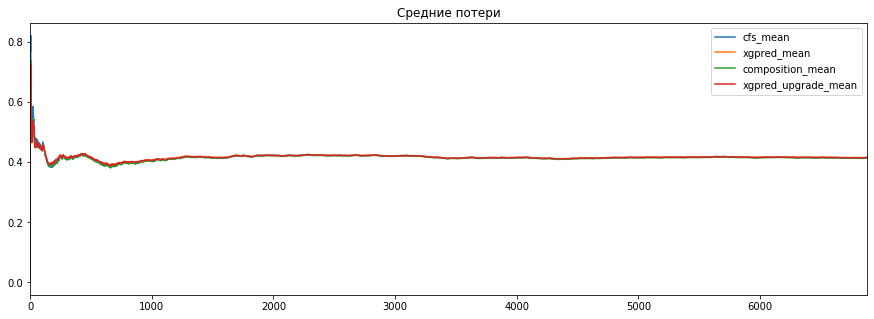

In [258]:
agg[['cfs_mean', 'xgpred_mean', 'composition_mean', 'xgpred_upgrade_mean']].plot(figsize=(15, 5), title='Средние потери')

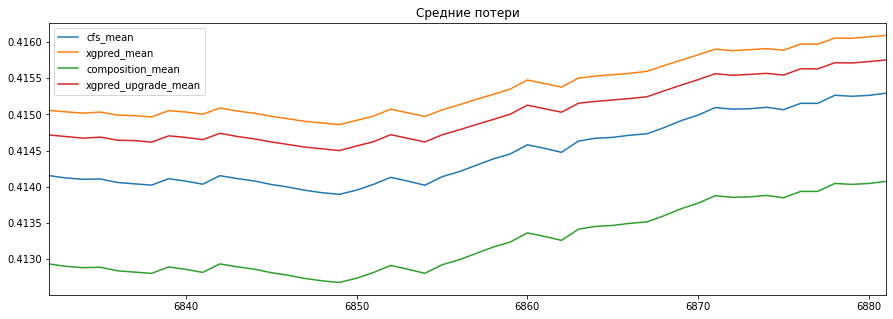

In [259]:
agg[['cfs_mean', 'xgpred_mean', 'composition_mean', 'xgpred_upgrade_mean']].tail(50).plot(figsize=(15, 5), title='Средние потери')

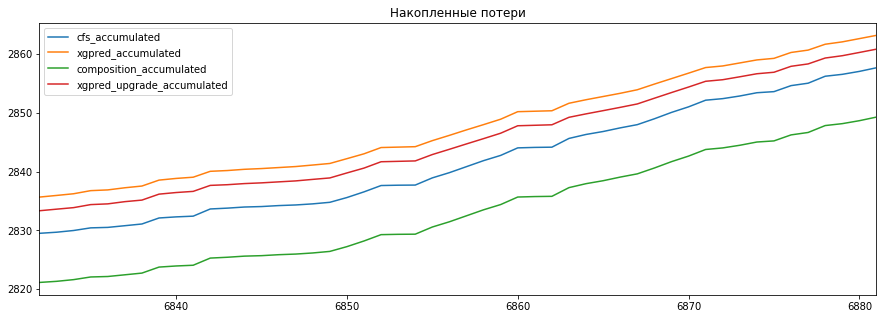

In [260]:
agg[['cfs_accumulated', 'xgpred_accumulated', 'composition_accumulated', 'xgpred_upgrade_accumulated']].tail(50).plot(figsize=(15, 5), title='Накопленные потери')